In [496]:
# imports
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
from geopy.distance import geodesic
import time
import sqlite3
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import json
from pathlib import Path

DATA_DIR = Path("data")
PATH_NEIGHBORHOOD = DATA_DIR / "Neighborhood_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv"
PATH_METRO_ZHVI = DATA_DIR / "Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv"
PATH_METRO_SALES = DATA_DIR / "Metro_median_sale_price_uc_sfrcondo_sm_week.csv"
PATH_METRO_SALES_RAW = DATA_DIR / "Metro_median_sale_price_uc_sfr_month.csv"
PATH_LOC = DATA_DIR / "Location_Data.json"
PATH_METRO_LOC = DATA_DIR / "Metro_Location_Data.json"
SQLITE_DB_URL = Path("zillow_stats.db")
DATE = "2025-01-31"

In [450]:
def melt_dataframes(df : pd.DataFrame, static_data : list, primary_key : str, value_name : str, var_name : str = "Date"):
    """
    Separates time series data from the data that does not change over time and melts the time series data

    Parameters:
        df (pd.DataFrame): The df containing the csv data
        static_data (list): A list of strings corresponding to the df column names that will not change
        primary_key (str): The column name of the primary key, which will be included in both returned DataFrames
        value_name (str): The name of the new column of melted data
        var_name (str): The column name on which the df will be melted on

    Returns:
        tuple:
            df_data (pd.DataFrame): A df containing all the data that will not change
            df_values (pd.DataFrame): A df containing all the melted data
    """
    static_copy = static_data.copy() # Needs to create a copy because Python, otherwise it changes the passed in version
    df_data = df[static_copy].drop_duplicates().reset_index(drop=True) # The drop_duplicates is not actually necessary, but good just in case
    if primary_key in static_copy:
        static_copy.remove(primary_key) # Used for making the other table later
    df_data[static_copy]=df_data[static_copy].astype('string') # Makes the data types of all columns except primary key strings instead of objects
    df_values = df.drop(columns=static_copy) # Removes the static data from the df, so just the cols we want melted down
    df_values = pd.melt(df_values, primary_key, var_name=var_name, value_name=value_name)
    if var_name == "Date":
        df_values[var_name] = pd.to_datetime(df_values[var_name]).dt.strftime("%Y-%m-%d") # Turns Date col into string rather than object to work better with SQLite
    df_values = df_values.dropna(subset=value_name) # Remove rows with empty data in the value col
    return df_data, df_values

In [451]:
df = pd.read_csv(PATH_NEIGHBORHOOD)

# These will be the columns of one of the tables
static_data = ["RegionID", "RegionName", "RegionType", "StateName", "City", "Metro", "CountyName"]

df.drop(columns=['State', 'SizeRank'], inplace=True) # Removes State and keeps StateName since they are completely identical
# SizeRank is 0 indexed, has duplicate values, and has a max value of 28019, which doesn't make sense with only 21636 rows.
# I don't understand its value and didn't plan on using it anways, so may as well get rid of it

df_data, df_values = melt_dataframes(df, static_data, "RegionID", "ZHVI")

In [452]:
coord_df = pd.read_json(PATH_LOC)
df_data = df_data.set_index("RegionID").join(coord_df.T).reset_index() # Adds the Latitude and Longitude from the json to the df

In [453]:
df_data.head()

,RegionID,RegionName,RegionType,StateName,City,Metro,CountyName,Latitude,Longitude
0,112345,Maryvale,neighborhood,AZ,Phoenix,"Phoenix-Mesa-Chandler, AZ",Maricopa County,33.492843,-112.223207
1,192689,Paradise,neighborhood,NV,Las Vegas,"Las Vegas-Henderson-Paradise, NV",Clark County,36.101122,-115.147933
2,270958,Upper West Side,neighborhood,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",New York County,40.787045,-73.975416
3,270957,Upper East Side,neighborhood,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",New York County,40.774383,-73.964641
4,118208,South Los Angeles,neighborhood,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,33.928291,-118.278813


In [454]:
df_values.head()

,RegionID,Date,ZHVI
0,112345,2000-01-31,67243.870428
1,192689,2000-01-31,131781.521430
2,270958,2000-01-31,375159.910493
3,270957,2000-01-31,615899.244168
4,118208,2000-01-31,127688.167292


In [455]:
metro_zhvi_df = pd.read_csv(PATH_METRO_ZHVI)
metro_sales_df = pd.read_csv(PATH_METRO_SALES)
metro_sales_raw_df = pd.read_csv(PATH_METRO_SALES_RAW)
metro_sales_raw_df.drop(columns=['SizeRank'], inplace=True)
metro_zhvi_df.drop(columns=['SizeRank'], inplace=True)
metro_sales_df.drop(columns=['SizeRank'], inplace=True)

static_loc_data = ["RegionID", "RegionName", "RegionType", "StateName"]
primary_key = "RegionID"
metro_loc_sales, metro_time_sales = melt_dataframes(metro_sales_df, static_loc_data, primary_key, "Median_Sales")
metro_loc_zhvi, metro_time_zhvi = melt_dataframes(metro_zhvi_df, static_loc_data, primary_key, "ZHVI")
metro_loc_sales_raw, metro_time_sales_raw = melt_dataframes(metro_sales_raw_df, static_loc_data, primary_key, "Median_Sales_Raw")


In [456]:
full_metro_loc = pd.concat([metro_loc_sales, metro_loc_zhvi, metro_loc_sales_raw], ignore_index=True).drop_duplicates() # Have to combine since all in one not necessarily in other
full_metro_loc.loc[full_metro_loc["RegionID"] == 102001, "StateName"] = "USA" # StateName is initally NaN for the United States
metro_coord_df = pd.read_json(PATH_METRO_LOC)
full_metro_loc = full_metro_loc.set_index("RegionID").join(metro_coord_df.T).reset_index() # Adds the Latitude and Longitude from the json to the df
full_metro_loc.head()

,RegionID,RegionName,RegionType,StateName,Latitude,Longitude
0,102001,United States,country,USA,39.783730,-100.445882
1,394913,"New York, NY",msa,NY,40.712728,-74.006015
2,753899,"Los Angeles, CA",msa,CA,34.053691,-118.242766
3,394463,"Chicago, IL",msa,IL,41.875562,-87.624421
4,394514,"Dallas, TX",msa,TX,32.776272,-96.796856


In [457]:
metro_time_sales.head()

,RegionID,Date,Median_Sales
0,102001,2008-02-23,169824.0
1,394913,2008-02-23,398625.0
2,753899,2008-02-23,467250.0
3,394463,2008-02-23,215875.0
4,394514,2008-02-23,135975.0


In [458]:
metro_time_zhvi.head()

,RegionID,Date,ZHVI
0,102001,2000-01-31,119729.572640
1,394913,2000-01-31,214911.652349
2,753899,2000-01-31,218489.647448
3,394463,2000-01-31,150432.480390
4,394514,2000-01-31,125268.936932


In [459]:
metro_time_sales_raw.head()

,RegionID,Date,Median_Sales_Raw
0,102001,2008-02-29,167000.0
1,394913,2008-02-29,400000.0
2,753899,2008-02-29,500000.0
3,394463,2008-02-29,215000.0
4,394514,2008-02-29,138000.0


In [460]:
# This class was used for preprocessing to get all the coords, taking >10000 minutes (even longer with the failed attempts). Do not run again if not needed 
class ZillowGeocoder:
    def __init__(self, user_agent : str="zillow_housing_plotting_project", timeout : int=10, rate_limit_delay : int=1):
        """
        Initializes the geocoder
        
        Parameters:
            user_agent (str): User agent for Nominatim
            timeout (int): Timeout in seconds for geocoding requests
            rate_limit_delay (int): Delay between requests in seconds
        """
        self.geolocator = Nominatim(user_agent=user_agent, timeout=timeout)
        self.rate_limit_delay = rate_limit_delay
        self.city_coords_cache = {}  # Cache for city coordinates
    
    def geocode(self, address : str, retry_count : int=0, max_retries : int=1):
        """
        Geocodes a given address
        
        Parameters:
            address (str): Address to geocode
            retry_count (int): Current retry attempt
            max_retries (int): Maximum number of retries
            
        Returns:
            tuple: (latitude, longitude) or (None, None) if geocoding fails
        """
        try:
            loc = self.geolocator.geocode(address)
            if loc:
                return loc.latitude, loc.longitude
            else:
                print(f"No results found for {address}")
                return None, None
                
        except GeocoderTimedOut:
            if retry_count < max_retries:
                print(f"Geocoding timed out for {address}, retrying... ({retry_count+1}/{max_retries})")
                time.sleep(2)
                return self.geocode(address, retry_count + 1, max_retries) # Calls itself recursively
            else:
                print(f"Max retries reached for {address}")
                return None, None
        except GeocoderUnavailable:
            print(f"Geocoding service unavailable for {address}")
            return None, None
        except Exception as e:
            print(f"Error geocoding {address}: {e}")
            return None, None
    
    def geocode_metro(self, region_name : str):
        """
        Geocode a metro region name
        
        Parameters:
            region_name (str): Name of the metro region
            
        Returns:
            tuple: (latitude, longitude) or (None, None) if geocoding fails
        """
        return self.geocode(region_name)
    
    def geocode_region(self, location : str, state : str, city : str):
        """
        Geocode a region and uses the city level as a fallback if the region geocoding fails
        
        Parameters:
            location (str): Region/neighborhood name
            state (str): State name
            city (str): City name for fallback
            
        Returns:
            tuple: (latitude, longitude) or (None, None) if geocoding fails
        """
        # Try specific location first
        full_address = f"{location}, {state}"
        lat, lon = self.geocode(full_address)
        
        # Fallback to city level if needed
        if lat is None and location != city: # No need to check lon since if lat is None, both are None
            print(f"Falling back to city level for {full_address}")
            broad_address = f"{city}, {state}"
            lat, lon = self.geocode(broad_address)
            
        return lat, lon
    
    def add_coordinates_to_df(self, df : pd.DataFrame, region_col : str="RegionName", state_col : str="StateName", city_col : str=None, method : str="region"):
        """
        Add latitude and longitude coordinates to the given df
        
        Parameters:
            df (pd.DataFrame): DataFrame containing location data
            region_col (str): Name of column in df containing region names
            state_col (str): Name of column in df containing state names
            city_col (str, optional): Name of column in df containing city names 
            method (str): "metro", "region", or "city" - determines geocoding approach
            
        Returns:
            pd.DataFrame: DataFrame with added Latitude and Longitude columns
        """
        result_df = df.copy() # Creates a copy to avoid the df passed in
        
        # Lists to hold geocoded results
        latitudes = []
        longitudes = []
        
        print(f'Starting geocoding for {len(df)} locations using {method} method')
        
        # Process each row in the DataFrame
        for idx, row in df.iterrows():
            if idx % 50 == 0 and idx > 0:
                print(f"Processed {idx}/{len(df)} locations") # Just to keep track of how many are done
                
            if method == "metro":
                lat, lon = self.geocode_metro(row[region_col]) # Metro-level geocoding
            elif method == "region" and city_col:
                lat, lon = self.geocode_region(row[region_col], row[state_col], row[city_col]) # Region-level geocoding with city fallback
            elif method == "city":
                address = f"{row[city_col]}, {row[state_col]}"
                lat, lon = self.geocode(address) # City-level geocoding
            else:
                address = f"{row[region_col]}, {row[state_col]}"
                lat, lon = self.geocode(address) # Default geocoding approach
            
            latitudes.append(lat)
            longitudes.append(lon)
            
            time.sleep(self.rate_limit_delay) # Sleeps to avoid rate limits
        
        # Add coordinates to DataFrame
        result_df['Latitude'] = latitudes
        result_df['Longitude'] = longitudes
        
        print(f"Geocoding complete. Successfully geocoded {sum(lat is not None for lat in latitudes)} out of {len(latitudes)} locations")
        
        return result_df
    
    def build_city_coordinates_cache(self, df : pd.DataFrame, city_col : str="City", state_col : str="StateName"):
        """
        Build a cache of city center coordinates to minimize API calls
        
        Parameters:
            df (pd.DataFrame): DataFrame containing city and state data
            city_col (str): Name of column in df containing city names
            state_col (str): Name of column in df containing state names
            
        Returns:
            dict: Dictionary mapping "City, State" to (latitude, longitude)
        """
        # Create unique city-state combinations
        unique_addresses = df[[city_col, state_col]].drop_duplicates().dropna()
        print(f"Need to geocode {len(unique_addresses)} unique city-state combinations")
        
        # Geocode each unique city-state combination
        for _, row in unique_addresses.iterrows():
            address = f"{row[city_col]}, {row[state_col]}"
            if address not in self.city_coords_cache:  # Check if already in cache
                coords = self.geocode(address)
                if coords[0] is not None:
                    self.city_coords_cache[address] = coords
                time.sleep(self.rate_limit_delay)
        
        print(f"Successfully geocoded {len(self.city_coords_cache)} cities")
        return self.city_coords_cache
    
    def find_misplaced_regions(self, df : pd.DataFrame, distance_threshold : int=250, 
                              city_col : str="City", state_col : str="StateName", 
                              lat_col : str="Latitude", lon_col : str="Longitude", 
                              id_col : str="RegionID"):
        """
        Find regions that are too far from their city centers
        
        Parameters:
            df (pd.DataFrame): DataFrame with coordinates and city information
            distance_threshold (int): Maximum allowed distance in miles from city center
            city_col (str): Name of column in df containing city names
            state_col (str): Name of column in df containing state names
            lat_col (str): Name of column in df containing latitudes
            lon_col (str): Name of column in df containing longitudes
            id_col (str): Name of column in df containing region IDs
            
        Returns:
            dict: Dictionary mapping region IDs to corrected city center coordinates
        """
        # Ensure we have city coordinates
        if not self.city_coords_cache:
            self.build_city_coordinates_cache(df, city_col, state_col)
        
        # Find misplaced regions
        region_id_coords = {}
        count = 0
        
        for _, row in df.iterrows():
            # Skip rows with missing data
            if (pd.isna(row[city_col]) or pd.isna(row[state_col]) or 
                pd.isna(row[lat_col]) or pd.isna(row[lon_col])):
                continue
                
            address = f"{row[city_col]}, {row[state_col]}"
            if address not in self.city_coords_cache:
                continue  # Skip if city not in cache
                
            # Calculate distance from city center
            try:
                current_coords = (row[lat_col], row[lon_col])
                city_center = self.city_coords_cache[address]
                distance = geodesic(current_coords, city_center).miles
                
                if distance > distance_threshold:
                    region_id_coords[row[id_col]] = city_center
                    count += 1
            except ValueError:
                # Handle invalid coordinate values
                continue
        
        print(f"Found {count} regions more than {distance_threshold} miles from their city centers")
        return region_id_coords
    
    def correct_misplaced_regions(self, df : pd.DataFrame, misplaced_regions : dict, 
                                 id_col : str="RegionID", lat_col : str="Latitude", lon_col : str="Longitude"):
        """
        Correct coordinates for misplaced regions
        
        Parameters:
            df (pd.DataFrame): DataFrame with region coordinates
            misplaced_regions (dict): Dictionary mapping region IDs to corrected coordinates
            id_col (str): Name of columns in df containing region IDs
            lat_col (str): Name of columns in df containing latitudes
            lon_col (str): Name of columns in df containing longitudes
            
        Returns:
            pd.DataFrame: DataFrame with corrected coordinates
        """
        result_df = df.copy()
        
        for region_id, coords in misplaced_regions.items():
            mask = result_df[id_col] == region_id
            result_df.loc[mask, lat_col] = coords[0]
            result_df.loc[mask, lon_col] = coords[1]
        
        print(f"Corrected coordinates for {len(misplaced_regions)} regions")
        return result_df

In [461]:
class DBManager: # All these functions access the db using the path, so may as well make a class
    def __init__(self, db_path=SQLITE_DB_URL):
        """
        Initializes using the given DB URL

        Parameters:
            db_path (str, default=SQLITE_DB_URL): Path to the SQLite database
        """
        self.db_path = db_path
        
    def table_to_df(self, table_name : str, cols : list=None):
        """
        Load data from a SQLite table into a pandas DataFrame
        
        Parameters:
            table_name (str): Name of the table to query
            cols (list, optional): Specific columns to select (defaults to all columns)
            
        Returns:
            pd.DataFrame: A DataFrame containing the queried data
        """
        with sqlite3.connect(self.db_path) as conn:
            # Check that the table exists
            cursor = conn.cursor()
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
            valid_tables = {row[0] for row in cursor.fetchall()}
            
            if table_name not in valid_tables:
                raise ValueError(f"Table '{table_name}' does not exist in the database")
            
            # If cols is specified, check that all of them exist in the table
            if cols:
                cursor.execute(f"PRAGMA table_info({table_name});")
                table_columns = {row[1] for row in cursor.fetchall()}
                
                invalid_cols = [col for col in cols if col not in table_columns]
                if invalid_cols:
                    raise ValueError(f"Invalid column(s) for table '{table_name}': {', '.join(invalid_cols)}")
                
                columns_str = ", ".join(cols)
                query = f"SELECT {columns_str} FROM {table_name}" # Creates the query with the specified columns
            else:
                query = f"SELECT * FROM {table_name}" # No cols specified, so selects them all
            
            return pd.read_sql_query(query, conn)

    def select_date_table(self, table_name : str, cols : list=None, date : str="newest"):
        """
        Load data from a SQLite table with dates into a pandas DataFrame
        
        Parameters:
            table_name (str): Name of the table to query
            cols (list, optional): Specific columns to select (defaults to all columns)
            date (str, optional, default="newest"): "newest", "oldest", or a specific date string to filter by
            
        Returns:
            pd.DataFrame: A DataFrame containing the queried data
        """
        with sqlite3.connect(self.db_path) as conn:
            cursor = conn.cursor()
            
            # Checks that the table exists
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
            valid_tables = {row[0] for row in cursor.fetchall()}
            
            if table_name not in valid_tables:
                raise ValueError(f"Table '{table_name}' does not exist in the database")
            
            # Gets all columns from the table
            cursor.execute(f"PRAGMA table_info({table_name});")
            table_columns = {row[1] for row in cursor.fetchall()}
            
            # Checks that the Date column exists in the table
            if "Date" not in table_columns:
                raise ValueError(f"Invalid table. There is no 'Date' column in '{table_name}'")
            
            # Handles date filtering
            date_condition = ""
            if date == "newest":
                date_query = f"SELECT MAX(Date) FROM {table_name}"
                cursor.execute(date_query)
                max_date = cursor.fetchone()[0]
                date_condition = f"WHERE Date = '{max_date}'"
            elif date == "oldest":
                date_query = f"SELECT MIN(Date) FROM {table_name}"
                cursor.execute(date_query)
                min_date = cursor.fetchone()[0]
                date_condition = f"WHERE Date = '{min_date}'"
            elif date:
                date_condition = f"WHERE Date = '{date}'"
            
            # Handles column selection
            if cols:
                invalid_cols = [col for col in cols if col not in table_columns]
                if invalid_cols:
                    raise ValueError(f"Invalid column(s) for table '{table_name}': {', '.join(invalid_cols)}")
                
                columns_str = ", ".join(cols)
            else:
                columns_str = "*"
            
            # Creates the query
            query = f"""
                SELECT {columns_str}
                FROM {table_name}
                {date_condition}
            """
            
            return pd.read_sql_query(query, conn)
        
    def select_merged_table(self, table_names : str, key : str="RegionID", key_value : str=None, cols : list=None, date : str=None):
        """
        Load data from multiple SQLite tables merged on a common key with optional date filtering
        
        Parameters:
            table_names (set or list): Names of the tables to be merged and queried
            key (str, default="RegionID"): The column name to join tables on
            cols (list or tuple, optional): Specific columns to select (defaults to all columns)
            date (str, optional): "newest", "oldest", or a specific date string to filter by
            
        Returns:
            pd.DataFrame: A DataFrame containing the merged data
        """
        table_list = list(table_names) # Converts to list for easier indexing
        
        if len(table_list) != 2: # Merging more tables is tough and shouldn't be necessary for the project
            raise ValueError("Can only merge exactly two tables.")
        
        with sqlite3.connect(self.db_path) as conn:
            cursor = conn.cursor()
            
            # Checks that all tables exist
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
            valid_tables = {row[0] for row in cursor.fetchall()}
            
            invalid_tables = [table for table in table_list if table not in valid_tables]
            if invalid_tables:
                raise ValueError(f"Table(s) '{', '.join(invalid_tables)}' do not exist in the database")
            
            # Finds the table with the Date column so it can be filtered properly
            date_table = None
            for table in table_list:
                cursor.execute(f"PRAGMA table_info({table});")
                columns = {row[1] for row in cursor.fetchall()}
                if "Date" in columns:
                    date_table = table
                    break
            
            if date_table is None:
                raise ValueError("None of the specified tables have a 'Date' column")
            
            # Get all columns from all tables to check against the requested columns
            all_columns = {}
            for table in table_list:
                cursor.execute(f"PRAGMA table_info({table});")
                all_columns[table] = {row[1] for row in cursor.fetchall()}
            
            # Validate the join key exists in both tables
            for table in table_list:
                if key not in all_columns[table]:
                    raise ValueError(f"Join key '{key}' not found in table '{table}'")
            
            # Handle date filtering
            date_condition = ""
            if date == "newest":
                date_query = f"SELECT MAX(Date) FROM {date_table}"
                cursor.execute(date_query)
                max_date = cursor.fetchone()[0]
                date_condition = f"{date_table}.Date = '{max_date}'"
            elif date == "oldest":
                date_query = f"SELECT MIN(Date) FROM {date_table}"
                cursor.execute(date_query)
                min_date = cursor.fetchone()[0]
                date_condition = f"{date_table}.Date = '{min_date}'"
            elif date:
                date_condition = f"{date_table}.Date = '{date}'"
            
            # Handle column selection
            if cols:
                # Check if specified columns exist in any of the tables
                available_cols = set()
                for table_cols in all_columns.values():
                    available_cols.update(table_cols)
                
                invalid_cols = [col for col in cols if col not in available_cols]
                if invalid_cols:
                    raise ValueError(f"Invalid column(s): {', '.join(invalid_cols)}")
                
                # Build column selection with table prefixes to avoid ambiguity
                select_cols = []
                for col in cols:
                    # Find which table(s) have this column
                    tables_with_col = [t for t in table_list if col in all_columns[t]]
                    if len(tables_with_col) == 1:
                        select_cols.append(f"{tables_with_col[0]}.{col}")
                    elif col == key:  # Join key appears in both tables, pick one
                        select_cols.append(f"{table_list[0]}.{col}")
                    else:  # Column appears in multiple tables, include both with aliases
                        for table in tables_with_col:
                            select_cols.append(f"{table}.{col} AS {table}_{col}")
                
                columns_str = ", ".join(select_cols)
            else:
                # Select all columns
                columns_str = "*"

            # Prepare key filter
            where_condition = ""
            if key_value:
                where_condition = f"{key} = {key_value}"

            # Combine conditions (instead of using multiple WHEREs)
            conditions = " AND ".join(filter(None, [date_condition, where_condition]))
            where_clause = f"WHERE {conditions}" if conditions else ""

            # Build the query
            query = f"""
                SELECT {columns_str}
                FROM {table_list[0]}
                JOIN {table_list[1]} USING ({key})
                {where_clause}
            """
            
            return pd.read_sql_query(query, conn)
        
    def add_to_table(self, table_name : str, df : pd.DataFrame):
        """
        Add or update records in a specified table using data from a DataFrame.
        
        Parameters:
            table_name (str): Name of the target table
            df (pd.DataFrame): DataFrame containing data to be added
        
        Return:
            int: Number of rows added
        """
        with sqlite3.connect(self.db_path) as conn:
            cursor = conn.cursor()

            # Checks if table exists
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
            valid_tables = {row[0] for row in cursor.fetchall()}
            if table_name not in valid_tables:
                raise ValueError(f"Invalid table name: {table_name}")
            
            # Gets column information
            cursor.execute(f"PRAGMA table_info({table_name});")
            table_columns = [row[1] for row in cursor.fetchall()]
            
            # Finds matching columns between the df and table
            df_columns = df.columns
            common_columns = [col for col in df_columns if col in table_columns]
            
            if not common_columns:
                raise ValueError(f"No matching columns found between given df and {table_name}")
            
            # Creates placeholders for the SQL query
            placeholders = ", ".join(["?" for _ in common_columns])
            columns_str = ", ".join(common_columns)
            
            # Creates INSERT statement to handle both new records
            insert_sql = f"""
                INSERT INTO {table_name} ({columns_str})
                VALUES ({placeholders})
            """
            
            # Prepares data for insertion
            insert_data = [
                tuple(row[col] for col in common_columns)
                for _, row in df.iterrows()
            ]
            
            # Execute and commit
            cursor.executemany(insert_sql, insert_data)
            conn.commit()
            
            return cursor.rowcount
    # Way used:
    # add_to_table("Metro_Location_Data", metro_loc_sales_raw)
    # continental_sales_raw_df[continental_sales_raw_df["RegionID"] == 753924]
    # continental_sales_raw_df.loc[continental_sales_raw_df["RegionID"] == 394437, "RegionName"] = "Canon City, CO"
    # continental_sales_raw_df.loc[continental_sales_raw_df["RegionID"] == 394437, "Latitude"] = 38.4422506
    # continental_sales_raw_df.loc[continental_sales_raw_df["RegionID"] == 394437, "Longitude"] = -105.2348795
    # continental_sales_raw_df[continental_sales_raw_df["RegionID"] == 394437]
    # add_to_table("Metro_Location_Data", continental_sales_raw_df[continental_sales_raw_df["RegionID"] == 394437])

    def safe_to_sqlite(self, df: pd.DataFrame, table_name: str):
        """
        Safely converts DataFrame into a SQLite table
            
        Parameters:
            df (pd.DataFrame): The DataFrame that is being added to the db
            table_name (str): The name that the table with have after it is added
        """
        with sqlite3.connect(self.db_path) as conn: # Should create the db if it does not already exist
            # Checks if table already exists
            cursor = conn.execute(
                "SELECT name FROM sqlite_master WHERE type='table' AND name=?;", (table_name,)
            )
            exists = cursor.fetchone() is not None

            if not exists:
                df.to_sql(table_name, conn, index=False)
                print(f"✅ Created '{table_name}'.")
            else:
                print(f"ℹ️ '{table_name}' already exists. Skipping...")

    def drop_column_sqlite(self, table_name : str, column_to_drop : str):
        """
        Drops a column from a table
            
        Parameters:
            table_name (str): The name of the table whose column is being removed
            column_to_drop (str): The name of the column that is being removed
        """
        with sqlite3.connect(self.db_path) as conn:
            cursor = conn.cursor()

            # Gets columns from the table
            cursor.execute(f"PRAGMA table_info({table_name})")
            columns_info = cursor.fetchall()
            all_columns = [col[1] for col in columns_info]

            if column_to_drop not in all_columns:
                raise ValueError(f"Column '{column_to_drop}' does not exist in table '{table_name}'.")

            columns_to_keep = [col for col in all_columns if col != column_to_drop]
            columns_str = ', '.join(columns_to_keep)

            # Gets column definitions (name and type) for new table
            new_columns_def = ', '.join(
                f"{col[1]} {col[2]}" for col in columns_info if col[1] != column_to_drop
            )

            # Creates new table and puts data from old table in
            cursor.executescript(f"""
                CREATE TABLE new_{table_name} ({new_columns_def});

                INSERT INTO new_{table_name} ({columns_str})
                SELECT {columns_str} FROM {table_name};

                DROP TABLE {table_name};

                ALTER TABLE new_{table_name} RENAME TO {table_name};
            """)

            conn.commit()

    def update_datetime_column_to_date(self, table_name : str, datetime_column : str):
        """
        Changes a column in the given table from data in a datetime to a date format

        Parameters:
            table_name (str): The name of the table which needs its column adjusted
            datetime_column (str): The name of the column which needs to be adjusted
        """
        with sqlite3.connect(self.db_path) as conn:
            cursor = conn.cursor()

            # Updates column with datetime to only store the date (YYYY-MM-DD instead of YYYY-MM-DD hours:minutes:seconds:milliseconds) 
            update_query = f"""
            UPDATE {table_name}
            SET {datetime_column} = DATE({datetime_column});
            """
            cursor.execute(update_query)
            conn.commit()
            
    def rename_column_in_sqlite(self, table_name : str, old_column : str, new_column : str):
        """
        Changes the name of the given column in the given table to a new name

        Parameters:
            table_name (str): The name of the table which needs its column adjusted
            old_column (str): The name of the column which needs to be adjusted
            new_column (str): The new name of the column
        """
        with sqlite3.connect(self.db_path) as conn:
            # Get the table's schema
            cursor = conn.cursor()
            cursor.execute(f"PRAGMA table_info({table_name});")
            columns = cursor.fetchall()
            
            if any(col[1] == old_column for col in columns): # Checks if column exists
                # Creates a new table with the updated column name
                columns_definition = ', '.join(
                    [f'"{col[1]}" {col[2]}' if col[1] != old_column else f'"{new_column}" {col[2]}'
                    for col in columns]
                )
                cursor.execute(f"""
                    CREATE TABLE new_{table_name} ({columns_definition});
                """)

                # Adds all the data into the new table from the old table
                cursor.execute(f"""
                    INSERT INTO new_{table_name} SELECT * FROM {table_name};
                """)

                # Drops the old table
                cursor.execute(f"DROP TABLE {table_name};")

                # Renames the new table to the old table's name
                cursor.execute(f"ALTER TABLE new_{table_name} RENAME TO {table_name};")

                print(f"Column {old_column} renamed to {new_column} successfully.")
            else:
                print(f"Column {old_column} does not exist in the table.")

            # Way used:
            # rename_column_in_sqlite('Metro_Sales_Data', 'Median Sales', 'Median_Sales')
            # rename_column_in_sqlite('Location_Data', 'State', 'StateName')

    def coordinates_to_json(self, table_name : str, output_dir: Path=DATA_DIR):
        """
        Extracts RegionID, Latitude, and Longitude from the given table and writes them to a JSON file

        Parameters:
            table_name (str): The name of the table to extract coordinate data from
            output_dir (str, default=DATA_DIR): Directory where the output JSON file will be saved

        Raises:
            ValueError: If the table does not exist or required columns are missing
        """
        with sqlite3.connect(self.db_path) as conn:
            cursor = conn.cursor()

            # Check if table exists
            cursor.execute("""
                SELECT name FROM sqlite_master
                WHERE type='table' AND name=?;
            """, (table_name,))
            if not cursor.fetchone():
                raise ValueError(f"Table '{table_name}' does not exist in the database.")

            # Check for RegionID, Latitude, and Longitude columns since they will be the key and attributes in the json 
            cursor.execute(f"PRAGMA table_info({table_name});")
            columns = {col[1] for col in cursor.fetchall()}
            required = {"RegionID", "Latitude", "Longitude"}
            if not required.issubset(columns):
                raise ValueError(f"Table '{table_name}' must contain columns: {required}")

            # Fetch data
            cursor.execute(f"""
                SELECT RegionID, Latitude, Longitude FROM {table_name}
                WHERE Latitude IS NOT NULL AND Longitude IS NOT NULL;
            """)
            rows = cursor.fetchall()

            coord_dict = {
                str(region_id): {"Latitude": lat, "Longitude": lon}
                for region_id, lat, lon in rows
            }

            # Write to file
            output_dir = Path(output_dir) # Casts to a Path object because Python isn't strongly typed
            output_dir.mkdir(parents=True, exist_ok=True)

            output_path = output_dir / f"{table_name}.json"

            with open(output_path, "w", encoding="utf-8") as f:
                json.dump(coord_dict, f, indent=2)

            print(f"Coordinate data written to '{output_path}'")

    def update_table_coords(self, full_update_df : pd.DataFrame, table_name : str):
        """
        Updates a row's Latitude and Longitude in the table using the given df 

        Parameters:
            full_update_df (pd.DataFrame): df with columns named "Latitude-Update", "Longitude-Update", and "RegionID"
            table_name (str): The name of the table to extract coordinate data from

        Raises:
            ValueError: If the table does not exist
        """
        with sqlite3.connect(self.db_path) as conn:
            cursor = conn.cursor()

            # Checks if table exists
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
            valid_tables = {row[0] for row in cursor.fetchall()}
            if table_name not in valid_tables:
                raise ValueError(f"Invalid table name: {table_name}")

            update_sql = f"""
                UPDATE {table_name}
                SET Latitude = ?, Longitude = ?
                WHERE RegionID = ?
            """

            update_data = [ # Creates a list of tuples with the latitude, longitude, and regionid from the passed in df
                (row["Latitude-Update"], row["Longitude-Update"], row["RegionID"])
                for _, row in full_update_df.iterrows()
            ]

            cursor.executemany(update_sql, update_data) # Uses the list of tuples and updates the table with it
            conn.commit()
            
        # Way used:
        # weird_df = merged_df[(merged_df["Latitude"] > 50) & (merged_df["StateName"] != "AK")]
        # weird_df
        # for index, row in weird_df.iterrows():
        #     lat, long = get_city_coords(f"{row['RegionName']}, {row['City']}, California")
        #     if lat:
        #         weird_df.at[index, "Latitude"] = lat
        #     if long:
        #         weird_df.at[index, "Longitude"] = long
        # weird_df.loc[weird_df["RegionID"] == 810129, "Latitude"] = 34.036232, 
        # weird_df.loc[weird_df["RegionID"] == 810129, "Longitude"] = -117.613777
        # weird_df
        # update_table_coords(weird_df, "Metro_Location_Data")

In [462]:
# Create a SQLite DB
DB = DBManager()
DB.safe_to_sqlite(df_data, "Location_Data")
DB.safe_to_sqlite(df_values, "ZHVI_Data")
DB.safe_to_sqlite(full_metro_loc, "Metro_Location_Data")
DB.safe_to_sqlite(metro_time_sales, "Metro_Sales_Data")
DB.safe_to_sqlite(metro_time_zhvi, "Metro_ZHVI_Data")
DB.safe_to_sqlite(metro_time_sales_raw, "Metro_Sales_Raw_Data")

# Adds indices to make the process more efficient
with sqlite3.connect(SQLITE_DB_URL) as conn:
    conn.execute("CREATE INDEX IF NOT EXISTS idx_housing_regionid ON Location_Data(RegionID);")
    conn.execute("CREATE INDEX IF NOT EXISTS idx_housing_regionid_date ON ZHVI_Data(RegionID, Date);")
    conn.execute("CREATE INDEX IF NOT EXISTS idx_metro_housing_regionid ON Metro_Location_Data(RegionID);")
    conn.execute("CREATE INDEX IF NOT EXISTS idx_metro_region_date_sales ON Metro_Sales_Data(RegionID, Date);")
    conn.execute("CREATE INDEX IF NOT EXISTS idx_metro_region_date_zhvi ON Metro_ZHVI_Data(RegionID, Date);")
    conn.execute("CREATE INDEX IF NOT EXISTS idx_metro_region_date_sales_raw ON Metro_Sales_Raw_Data(RegionID, Date);")

# DB.coordinates_to_json("Location_Data") # Used to create the jsons, which are more feasible to send to other users, as opposed to the whole db
# DB.coordinates_to_json("Metro_Location_Data")

ℹ️ 'Location_Data' already exists. Skipping...
ℹ️ 'ZHVI_Data' already exists. Skipping...
ℹ️ 'Metro_Location_Data' already exists. Skipping...
ℹ️ 'Metro_Sales_Data' already exists. Skipping...
ℹ️ 'Metro_ZHVI_Data' already exists. Skipping...
ℹ️ 'Metro_Sales_Raw_Data' already exists. Skipping...


In [463]:
metro_loc = DB.table_to_df("Metro_Location_Data")
metro_loc.head()

,RegionID,RegionName,RegionType,StateName,Latitude,Longitude
0,102001,United States,country,USA,39.783730,-100.445882
1,394913,"New York, NY",msa,NY,40.712728,-74.006015
2,753899,"Los Angeles, CA",msa,CA,34.053691,-118.242766
3,394463,"Chicago, IL",msa,IL,41.875562,-87.624421
4,394514,"Dallas, TX",msa,TX,32.776272,-96.796856


In [464]:
metro_sales = DB.table_to_df("Metro_Sales_Data")
metro_sales.head()

,RegionID,Date,Median_Sales
0,102001,2008-02-23,169824.0
1,394913,2008-02-23,398625.0
2,753899,2008-02-23,467250.0
3,394463,2008-02-23,215875.0
4,394514,2008-02-23,135975.0


In [465]:
metro_zhvi = DB.table_to_df("Metro_ZHVI_Data")
metro_zhvi.head()

,RegionID,Date,ZHVI
0,102001,2000-01-31,119729.572640
1,394913,2000-01-31,214911.652349
2,753899,2000-01-31,218489.647448
3,394463,2000-01-31,150432.480390
4,394514,2000-01-31,125268.936932


In [466]:
metro_sales_raw = DB.table_to_df("Metro_Sales_Raw_Data")
metro_sales_raw.head()

,RegionID,Date,Median_Sales_Raw
0,102001,2008-02-29,167000.0
1,394913,2008-02-29,400000.0
2,753899,2008-02-29,500000.0
3,394463,2008-02-29,215000.0
4,394514,2008-02-29,138000.0


In [467]:
location_df = DB.table_to_df("Location_Data")
location_df.head()

,RegionID,RegionName,RegionType,StateName,City,Metro,CountyName,Latitude,Longitude
0,112345,Maryvale,neighborhood,AZ,Phoenix,"Phoenix-Mesa-Chandler, AZ",Maricopa County,33.492843,-112.223207
1,192689,Paradise,neighborhood,NV,Las Vegas,"Las Vegas-Henderson-Paradise, NV",Clark County,36.101122,-115.147933
2,270958,Upper West Side,neighborhood,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",New York County,40.787045,-73.975416
3,270957,Upper East Side,neighborhood,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",New York County,40.774383,-73.964641
4,118208,South Los Angeles,neighborhood,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,33.928291,-118.278813


In [468]:
ZHVI_df = DB.select_date_table("ZHVI_Data")
ZHVI_df.head()

,RegionID,Date,ZHVI
0,112345,2025-01-31,3.360984e+05
1,192689,2025-01-31,3.933752e+05
2,270958,2025-01-31,1.216508e+06
3,270957,2025-01-31,1.200718e+06
4,118208,2025-01-31,6.760528e+05


In [497]:
merged_df = DB.select_merged_table(("ZHVI_Data", "Location_Data"), date=DATE)
continental_df = merged_df[(merged_df["StateName"] != "HI") & (merged_df["StateName"] != "AK")] # Want to focus on lower 48
continental_df.head()

,RegionID,Date,ZHVI,RegionName,RegionType,StateName,City,Metro,CountyName,Latitude,Longitude
0,112345,2025-01-31,3.360984e+05,Maryvale,neighborhood,AZ,Phoenix,"Phoenix-Mesa-Chandler, AZ",Maricopa County,33.492843,-112.223207
1,192689,2025-01-31,3.933752e+05,Paradise,neighborhood,NV,Las Vegas,"Las Vegas-Henderson-Paradise, NV",Clark County,36.101122,-115.147933
2,270958,2025-01-31,1.216508e+06,Upper West Side,neighborhood,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",New York County,40.787045,-73.975416
3,270957,2025-01-31,1.200718e+06,Upper East Side,neighborhood,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",New York County,40.774383,-73.964641
4,118208,2025-01-31,6.760528e+05,South Los Angeles,neighborhood,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,33.928291,-118.278813


In [498]:
merged_sales_raw_df = DB.select_merged_table(("Metro_Sales_Raw_Data", "Metro_Location_Data"), date=DATE)
continental_sales_raw_df = merged_sales_raw_df[(merged_sales_raw_df["StateName"] != "HI") & (merged_sales_raw_df["StateName"] != "AK") & (merged_sales_raw_df["StateName"] != "USA")]
continental_sales_raw_df.head()

,RegionID,Date,Median_Sales_Raw,RegionName,RegionType,StateName,Latitude,Longitude
1,394913,2025-01-31,663500.0,"New York, NY",msa,NY,40.712728,-74.006015
2,753899,2025-01-31,933500.0,"Los Angeles, CA",msa,CA,34.053691,-118.242766
3,394463,2025-01-31,310000.0,"Chicago, IL",msa,IL,41.875562,-87.624421
4,394514,2025-01-31,375000.0,"Dallas, TX",msa,TX,32.776272,-96.796856
5,394692,2025-01-31,324500.0,"Houston, TX",msa,TX,29.758938,-95.367697


In [499]:
merged_metro_zhvi_df = DB.select_merged_table(("Metro_ZHVI_Data", "Metro_Location_Data"), date=DATE)
continental_metro_zhvi_df = merged_metro_zhvi_df[(merged_metro_zhvi_df["StateName"] != "HI") & (merged_metro_zhvi_df["StateName"] != "AK") & (merged_metro_zhvi_df["StateName"] != "USA")]
continental_metro_zhvi_df.head()

,RegionID,Date,ZHVI,RegionName,RegionType,StateName,Latitude,Longitude
1,394913,2025-01-31,675063.976036,"New York, NY",msa,NY,40.712728,-74.006015
2,753899,2025-01-31,950740.494586,"Los Angeles, CA",msa,CA,34.053691,-118.242766
3,394463,2025-01-31,322389.516129,"Chicago, IL",msa,IL,41.875562,-87.624421
4,394514,2025-01-31,368515.900537,"Dallas, TX",msa,TX,32.776272,-96.796856
5,394692,2025-01-31,305480.078502,"Houston, TX",msa,TX,29.758938,-95.367697


In [ ]:
class PlottingModels:
    def plot_housing_map(df : pd.DataFrame, col : pd.Series, cluster : bool=False, 
                         n_clusters : int=10, value_name : str=None, figsize : tuple=(12, 10)):
        """
        Plots housing data on a map of the continental US, with the option of clustering.
        
        Parameters:
            df (pd.DataFrame): Merged DataFrame containing housing data with Latitude and Longitude columns
            col (pd.Series): Column from the passed in df that will be plotted
            cluster (bool, default=False): If True, perform KMeans clustering on the data
            n_clusters (int, default=10): Number of clusters for KMeans (only used if cluster=True) 
            value_name (str, optional): Name of the value being mapped
            figsize (tuple, default=(12, 10)): Figure size for the plot
            
        Returns:
            fig, ax (matplotlib figure and axis objects)
        """
        # Create GeoDataFrame
        gdf = gpd.GeoDataFrame(
            df,
            geometry=gpd.points_from_xy(df.Longitude, df.Latitude),
            crs="EPSG:4326"  # WGS 84 — standard lat/lon
        )

        gdf["RequestedCol"] = col
        
        # Extract lat/lon explicitly (needed for clustering)
        gdf["Latitude"] = gdf.geometry.y
        gdf["Longitude"] = gdf.geometry.x

        # Perform clustering if requested
        if cluster:
            # Normalize and Cluster
            features = gdf[["Latitude", "Longitude", "RequestedCol"]]
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(features)
            
            # Apply KMeans clustering
            kmeans = KMeans(n_clusters=n_clusters, random_state=0)
            gdf["cluster"] = kmeans.fit_predict(X_scaled)
        
        # Sets up Cartopy map
        fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})
        
        # Adds Cartopy features
        ax.add_feature(cfeature.LAND, facecolor='white')
        ax.add_feature(cfeature.BORDERS, edgecolor='black')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.STATES, edgecolor='gray', linewidth=0.5)
        
        # Restricts view to continental US
        ax.set_extent([-130, -65, 24, 50], crs=ccrs.PlateCarree())
        
        if cluster:
            # Plot with clusters
            scatter = gdf.plot(
                ax=ax,
                column="cluster",
                cmap="tab10",           # Distinct colors for clusters
                legend=True,
                markersize=20,
                alpha=0.8,
                transform=ccrs.PlateCarree()
            )
            if value_name:
                new_title = f"KMeans Clustering of {value_name} by Location and Value"
            else:
                new_title = "KMeans Clustering of Housing Prices by Location and Value"
        else:
            # Calculate IQR bounds for better color scaling
            Q1 = gdf["RequestedCol"].quantile(0.25)
            Q3 = gdf["RequestedCol"].quantile(0.75)
            IQR = Q3 - Q1
            
            vmin = Q1 - 1.5 * IQR
            vmax = Q3 + 1.5 * IQR
            
            # Clamp values so outliers don't mess up the scale
            vmin = max(vmin, gdf["RequestedCol"].min())
            vmax = min(vmax, gdf["RequestedCol"].max())
            
            # Plot with continuous color
            scatter = gdf.plot(
                ax=ax,
                column="RequestedCol",
                cmap="viridis",
                legend=True,
                markersize=20,
                alpha=0.7,
                vmax=vmax,
                vmin=vmin,
                transform=ccrs.PlateCarree()
            )
            if value_name:
                new_title = value_name
            else:
                new_title = "Housing Prices"
        
        # Set title with date
        if df["Date"].max():
            ax.set_title(f"{new_title} as of {df["Date"].max()}")
        else:
            ax.set_title(new_title)
        
        # Add credit for OpenStreetMap
        fig.text(
            .2, 0.01,
            "Coordinate Data from OpenStreetMap", 
            fontsize=11, color='black',
            ha='right', va='bottom'
        )
        
        plt.tight_layout()
        plt.show()
        
        return fig, ax

    def elbow_method(df : pd.DataFrame, col : str):
        """
        Performs the elbow omethod on the requested column in df to determine optimal amount for clustering

        Parameters:
            df (pd.DataFrame): DataFrame with Latitude and Longitude, which will are features for clustering
            col (str): Name of a column in the df which will have its values used as a third feature in the clustering
        """
        if "Latitude" not in df.columns or "Longitude" not in df.columns:
            print("Missing coordinate data.")
            return
        
        x = df.loc[:, [col, "Latitude", "Longitude"]]
        wcss = []
        for i in range(1, 50):
            kmeans= KMeans(i)
            kmeans.fit(x)
            wcss_iter = kmeans.inertia_
            wcss.append(wcss_iter)

        number_clusters = range(1, 50)
        plt.plot(number_clusters, wcss)
        plt.title('Elbow')
        plt.xlabel('Number of Clusters')
        plt.ylabel('WCSS')

    def plot_time_series(region_ids : list, time_series_table : str, location_table : str, 
                         value_column : str, id_column : str="RegionID", name_column : str="RegionName", date_column : str="Date",
                         figsize : tuple=(12, 6), title : str=None, y_label : str=None, db_path : str=SQLITE_DB_URL):
        """
        Plot multiple time series from different regions on the same chart.
        
        Parameters:
            region_ids (list): List of region IDs to plot
            time_series_table (str): Name of the table containing time series data
            location_table (str): Name of the table containing location data
            value_column (str): Name of the column containing values to plot on y axis
            id_column (str): Name of the column containing region IDs
            name_column (str): Name of the column containing region names
            date_column (str): Name of the column containing dates
            figsize (tuple, default=(12,6)): Figure size of the plot
            title (str, optional): Plot title (defaults to '{value_column} Over Time by Region' if not given)
            y_label (str, optional): Y-axis label (defaults to value_column if not given)
            db_path (str, default=SQLITE_DB_URL):

        Raises:
            ValueError: If the table does not exist or required columns are missing
        """
        # Create placeholders for SQL IN clause
        placeholders = ','.join(['?' for _ in region_ids])
        
        # Construct the SQL query dynamically
        query = f"""
            SELECT ts.{date_column}, ts.{value_column}, loc.{name_column}, loc.{id_column}
            FROM {time_series_table} ts
            JOIN {location_table} loc USING ({id_column})
            WHERE loc.{id_column} IN ({placeholders})
        """
        with sqlite3.connect(db_path) as conn:
            # Checks that the tables exist
            cursor = conn.cursor()
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
            valid_tables = {row[0] for row in cursor.fetchall()}
            
            for table in [time_series_table, location_table]:
                if time_series_table not in valid_tables or location_table not in valid_tables:
                    raise ValueError(f"'{table}' does not exist in the database")

                # Checks if the expected columns are in their expected tables
                if table == time_series_table:
                    cursor.execute(f"PRAGMA table_info({table});")
                    table_columns = {row[1] for row in cursor.fetchall()}
                    
                    for col in [id_column, date_column, value_column]:
                        if col not in table_columns:
                            raise ValueError(f"'{col}' does not exist in '{table}'")
                        
                elif table == location_table:
                    cursor.execute(f"PRAGMA table_info({table});")
                    table_columns = {row[1] for row in cursor.fetchall()}
                    
                    for col in [id_column, name_column]:
                        if col not in table_columns:
                            raise ValueError(f"'{col}' does not exist in '{table}'")
                
            all_data = pd.read_sql_query(query, conn, params=region_ids) # Fetch data
        all_data[date_column] = pd.to_datetime(all_data[date_column], errors="coerce")
        
        # Setup plot
        plt.figure(figsize=figsize)
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.xticks(rotation=45)

        num_regions = len(region_ids)
        colors = cm.viridis(np.linspace(0, 1, num_regions))

        for i, region_id in enumerate(region_ids):
            region_data = all_data[all_data[id_column] == region_id]
            if region_data.empty:
                continue
            ts = region_data.set_index(date_column)[value_column]
            plt.plot(ts, color=colors[i], label=region_data[name_column].iloc[0])

        plt.xlabel('Date')
        plt.ylabel(y_label if y_label else value_column)
        plt.title(title if title else f'{value_column} Over Time by Region')
        if len(region_ids) <= 10:
            plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        return

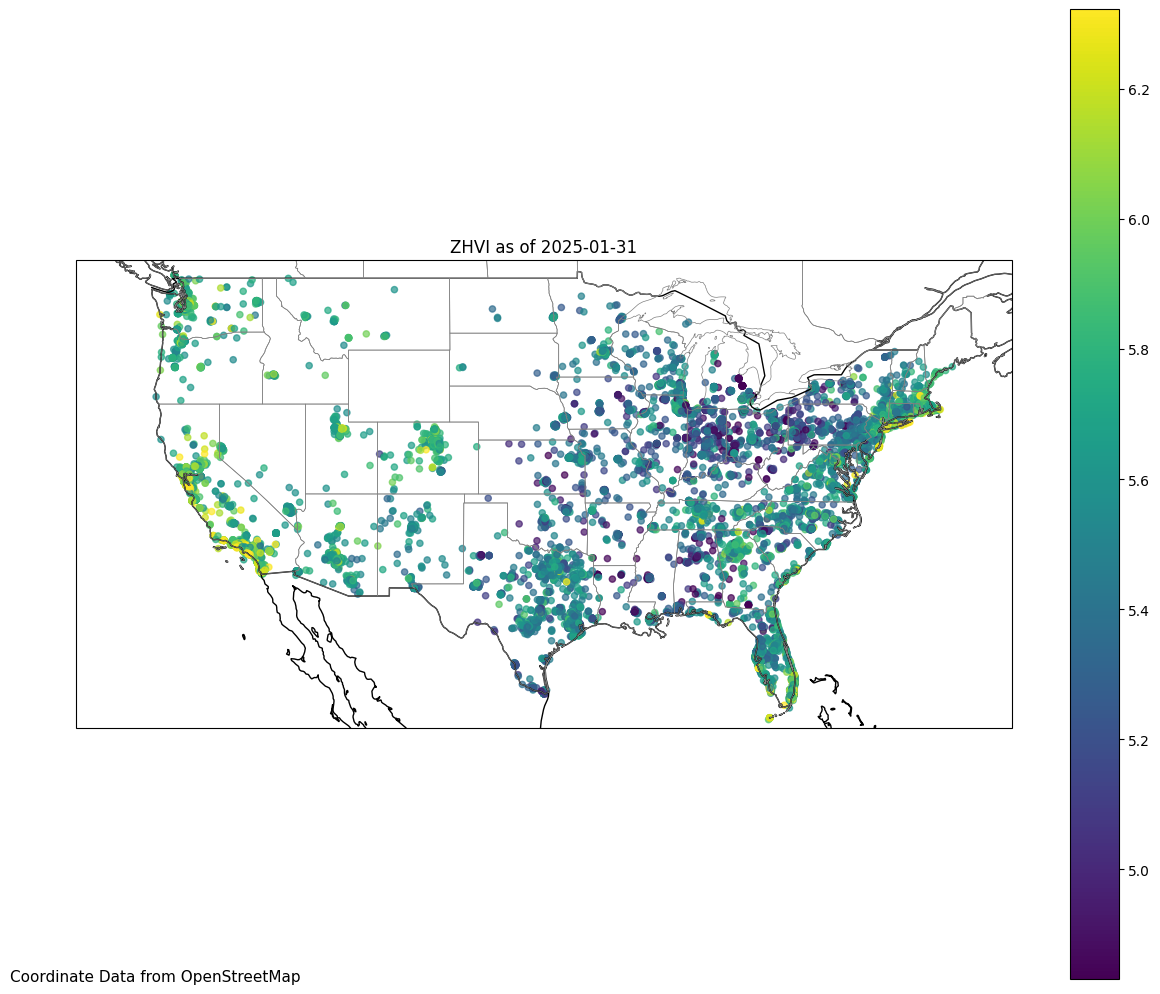

(<Figure size 1200x1000 with 2 Axes>,
 <GeoAxes: title={'center': 'ZHVI as of 2025-01-31'}>)

In [500]:
PlottingModels.plot_housing_map(continental_df, np.log10(continental_df["ZHVI"]), value_name="ZHVI")

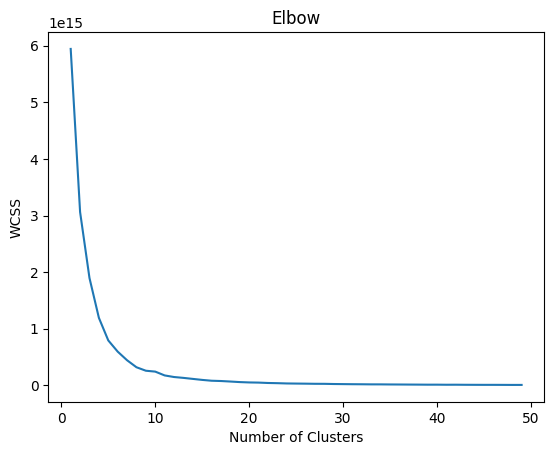

In [501]:
PlottingModels.elbow_method(continental_df, "ZHVI")

Around 10 clusters, or maybe even a couple less than 10, seems to be the point where more clusters does not improve the model.

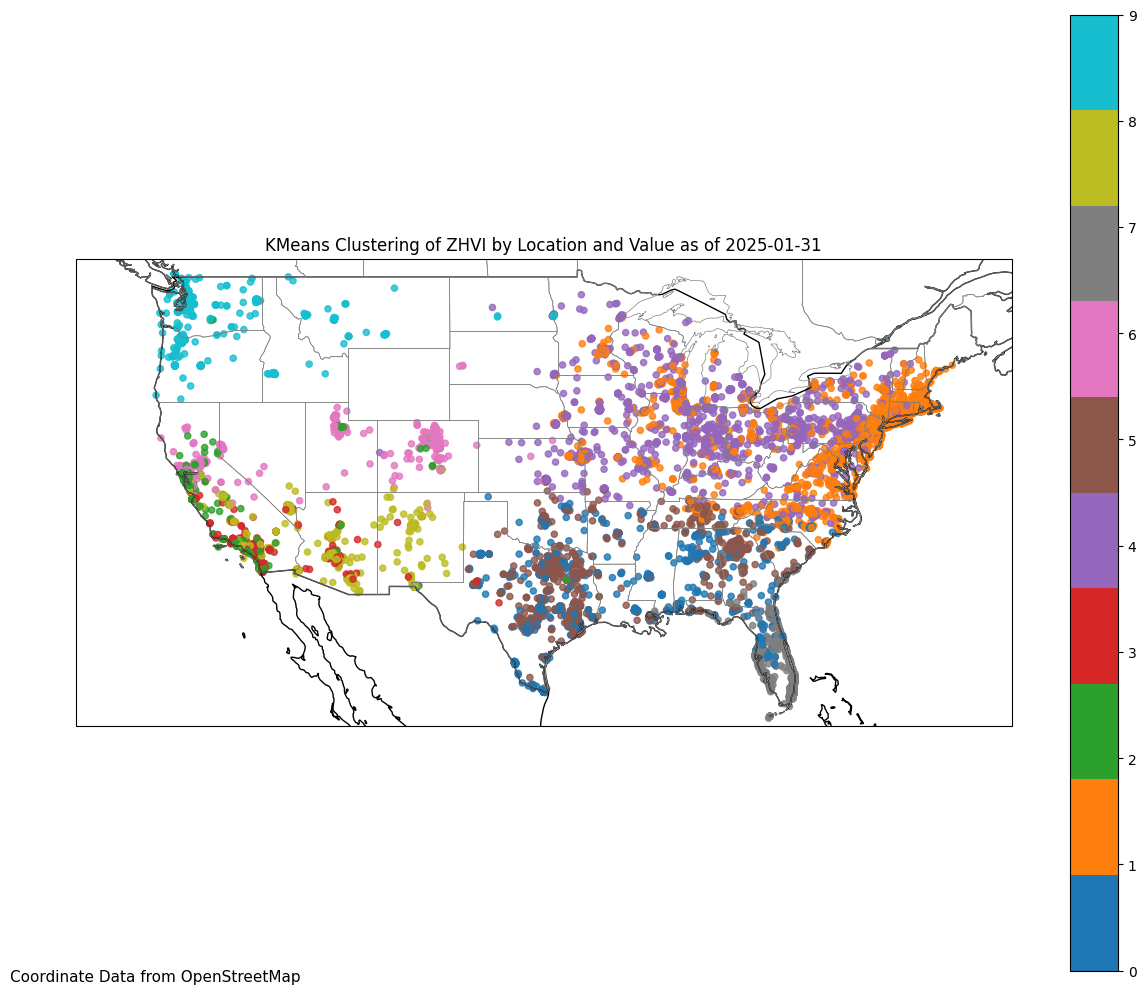

(<Figure size 1200x1000 with 2 Axes>,
 <GeoAxes: title={'center': 'KMeans Clustering of ZHVI by Location and Value as of 2025-01-31'}>)

In [502]:
PlottingModels.plot_housing_map(continental_df, np.log10(continental_df["ZHVI"]), cluster=True, value_name="ZHVI")

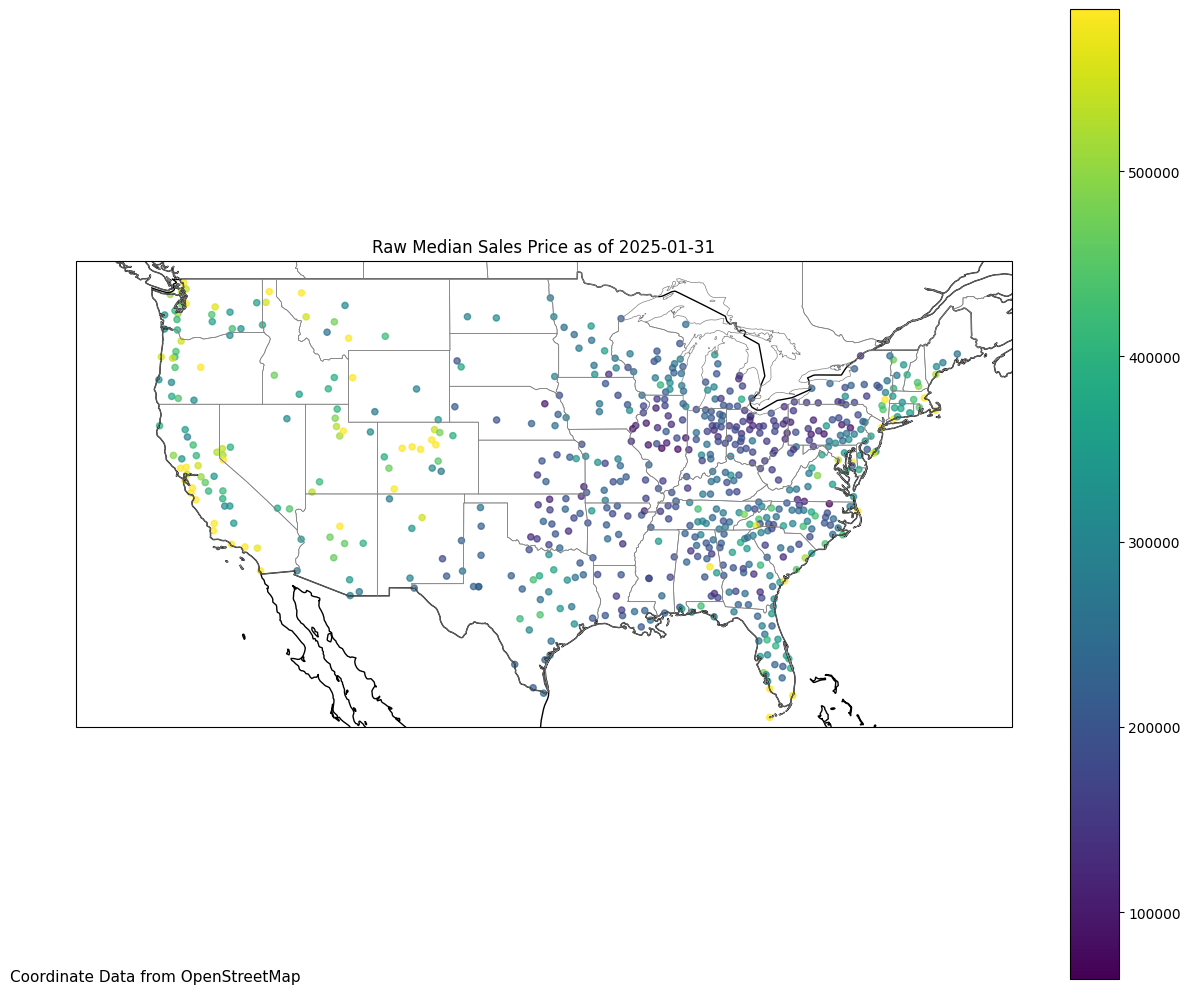

(<Figure size 1200x1000 with 2 Axes>,
 <GeoAxes: title={'center': 'Raw Median Sales Price as of 2025-01-31'}>)

In [503]:
PlottingModels.plot_housing_map(continental_sales_raw_df, continental_sales_raw_df["Median_Sales_Raw"], value_name="Raw Median Sales Price")

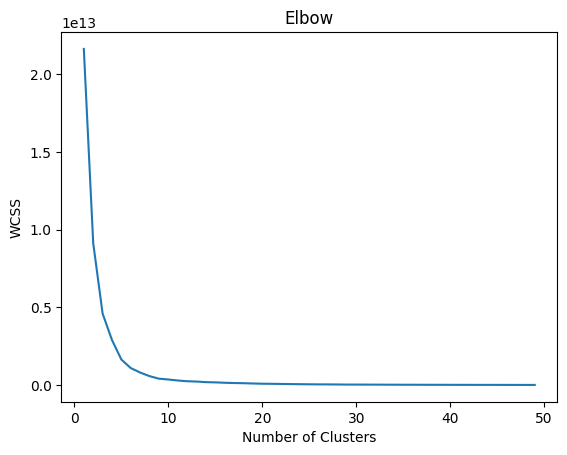

In [504]:
PlottingModels.elbow_method(continental_sales_raw_df, "Median_Sales_Raw")

Seems to take a bit less than 10 clusters

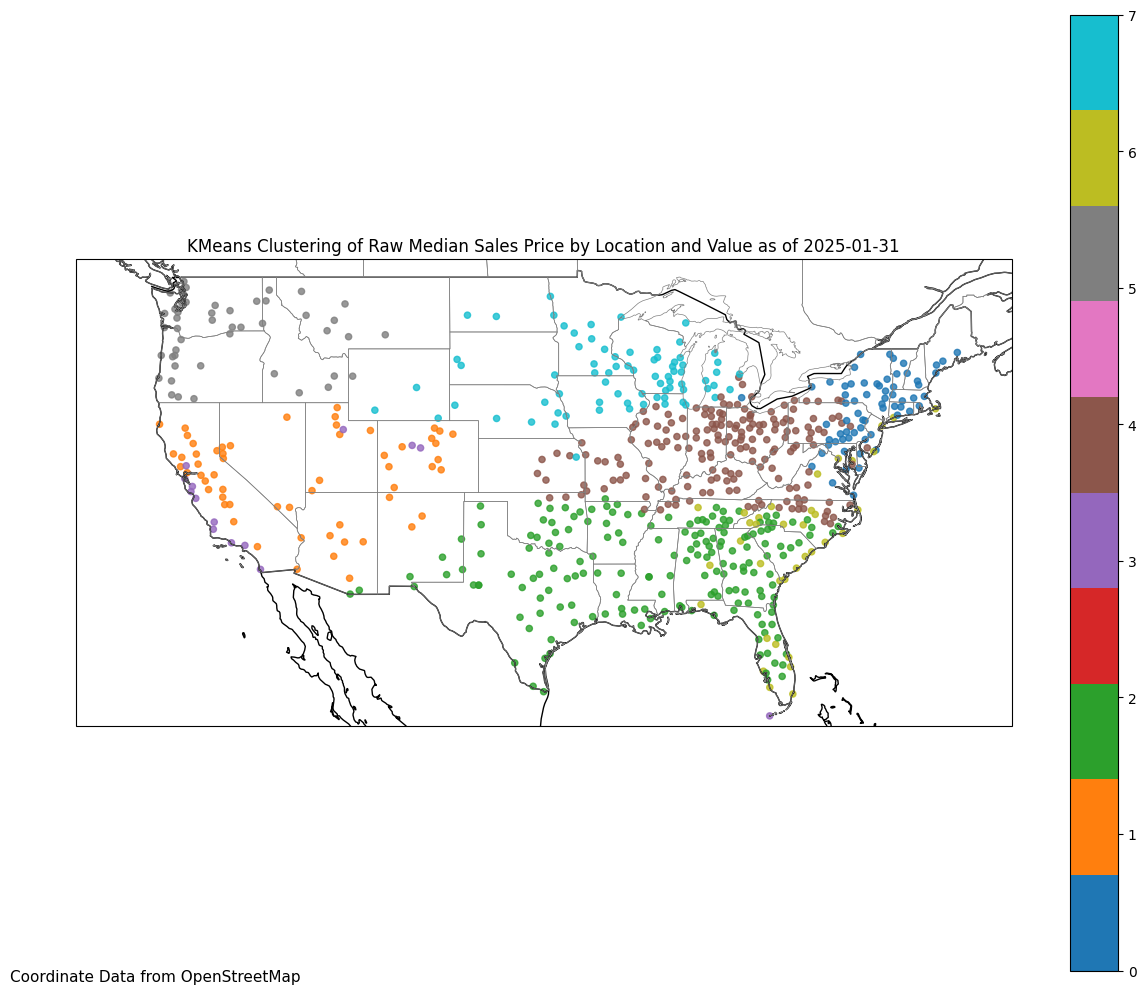

(<Figure size 1200x1000 with 2 Axes>,
 <GeoAxes: title={'center': 'KMeans Clustering of Raw Median Sales Price by Location and Value as of 2025-01-31'}>)

In [507]:
PlottingModels.plot_housing_map(continental_sales_raw_df, continental_sales_raw_df["Median_Sales_Raw"], cluster=True, value_name="Raw Median Sales Price", n_clusters=8)

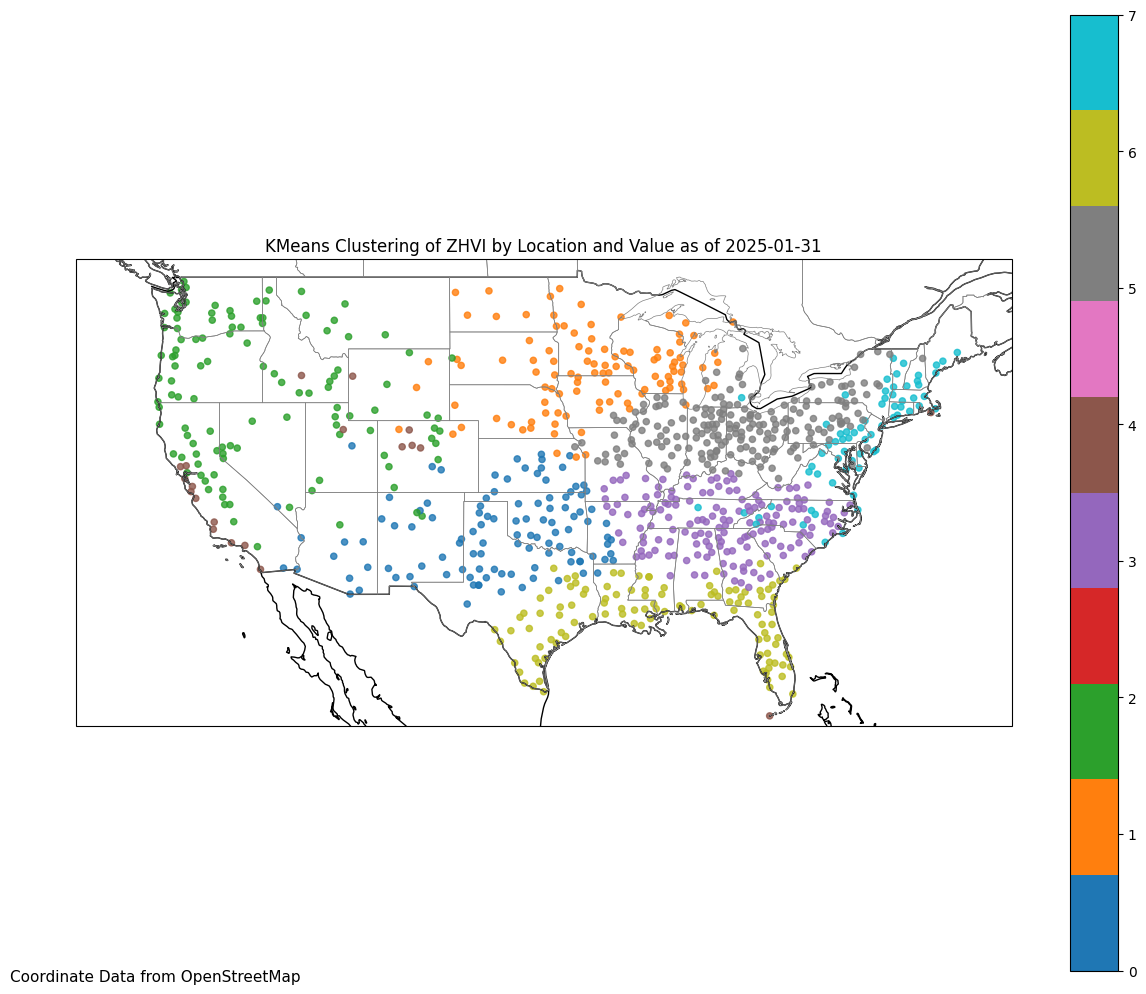

(<Figure size 1200x1000 with 2 Axes>,
 <GeoAxes: title={'center': 'KMeans Clustering of ZHVI by Location and Value as of 2025-01-31'}>)

In [508]:
PlottingModels.plot_housing_map(continental_metro_zhvi_df, continental_metro_zhvi_df["ZHVI"], cluster=True, value_name="ZHVI", n_clusters=8)

ZHVI does not appear to be equivalent to the raw sales data. The main change is that in the raw median sales data, there is one large cluster in the sun belt, but in the ZHVI data it becomes one cluster. To replace it, most of the American west is one cluster, whereas in the raw median sales data, it used to be divided at the border of Oregon and California.

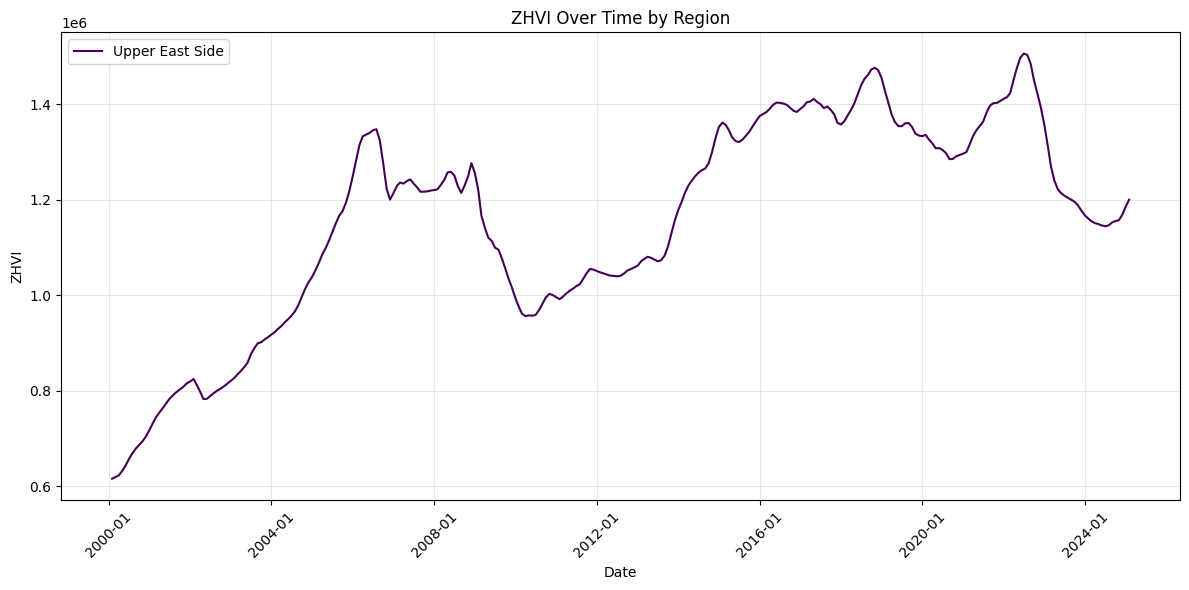

In [479]:
examined_id = 270957 # Upper east side, NY
PlottingModels.plot_time_series([examined_id], "ZHVI_Data", "Location_Data", "ZHVI")

In [480]:
all_metro_ids_df = DB.table_to_df("Metro_Sales_Raw_Data", cols=["RegionID"]).drop_duplicates()
all_metro_ids = all_metro_ids_df.iloc[:, 0].tolist()

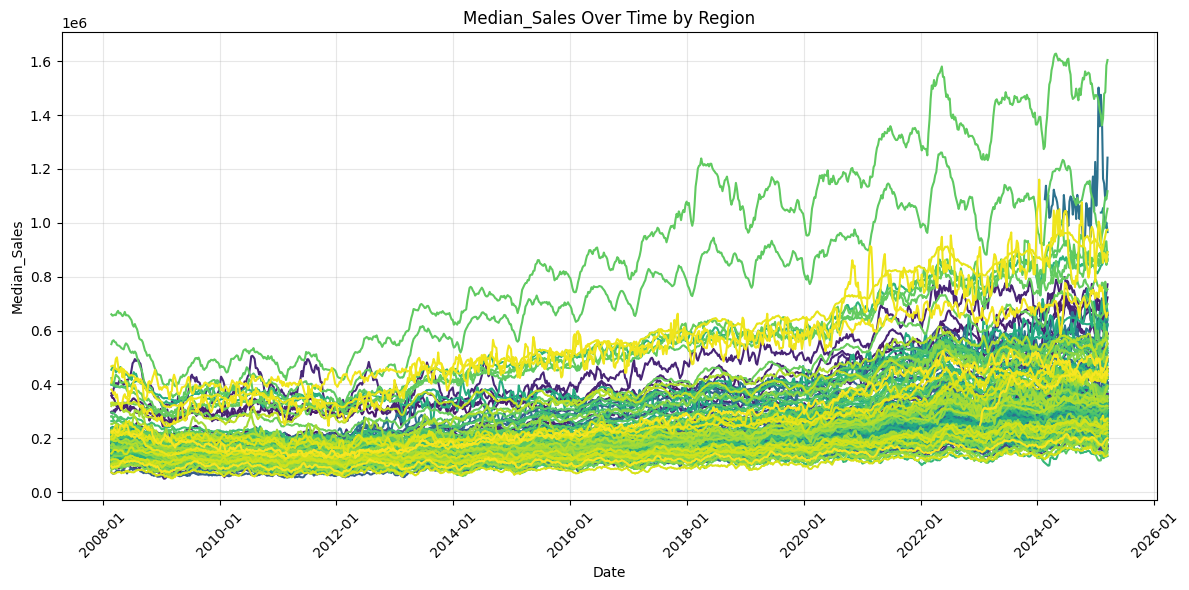

In [482]:
PlottingModels.plot_time_series(all_metro_ids, "Metro_Sales_Data", "Metro_Location_Data", "Median_Sales", legend=False)

In [488]:
def sample_of_regions(df : pd.DataFrame, col : str, required_regions : list = None, max_rows : int=10):
    """
    Gets a specified number of region ids from the given dataframe, based on the passed in col. Meant for non location tables.

    Parameters:
        df (pd.DataFrame): The DataFrame where the ids are coming from
        col (str): Name of a numerical column of df which will help determine the return
        required_regions (list): List of region ids that must be returned
        max_rows (int): Number of rows returned

    Returns:
        list (list): list of region ids (ints)
    """
    if "Date" not in df.columns:
        print("Expected a date column")
        return None
    
    df = df[df["Date"] == df["Date"].max()] # Sort by most recent data

    sorted_df = df.sort_values(col).reset_index(drop=True)

    # Remove outliers
    Q1 = sorted_df[col].quantile(0.25)
    Q3 = sorted_df[col].quantile(0.75)
    IQR = Q3 - Q1

    minimum = Q1 - 1.5 * IQR
    maximum = Q3 + 1.5 * IQR

    sorted_df = sorted_df[(sorted_df[col] > minimum) & (sorted_df[col] < maximum)]

    min_row = sorted_df.iloc[[0]]
    max_row = sorted_df.iloc[[-1]]
    median_value = sorted_df[col].median()
    median_row = sorted_df.iloc[[(sorted_df[col] - median_value).abs().argmin()]]
    filtered_df = sorted_df[sorted_df['RegionID'].isin(required_regions)]

    # Collect all indices to drop
    drop_indices = set(filtered_df.index)  # all matched rows
    drop_indices.update([min_row.index[0], max_row.index[0], median_row.index[0]])  # add the other specified rows

    # Drop them
    no_dupes_sorted_df = sorted_df.drop(drop_indices)

    remaining_rows = max_rows - (len(sorted_df) - len(no_dupes_sorted_df))

    # Sample rows
    step = max(1, len(no_dupes_sorted_df) // (remaining_rows))
    sampled_rows = no_dupes_sorted_df.iloc[::step].head(remaining_rows)

    good_mix_of_regions = pd.concat([min_row, median_row, max_row, filtered_df, sampled_rows]).sort_index() # Sort again since sampled are just tacked on after the others
    return good_mix_of_regions["RegionID"].tolist()

def state_regions(df : pd.DataFrame, state : str):
    """
    Gets the regionIDs of the specified state. Meant for merged tables.
    """
    if "StateName" not in df.columns:
        print("Expected a 'StateName' column")
        return None
    
    df = df[df["Date"] == df["Date"].max()] # Sort by most recent data

    filtered_df = df[df['StateName'].str.lower() == state.lower()].drop_duplicates(subset='RegionID') # All the tables have RegionIDs

    return filtered_df["RegionID"].tolist()

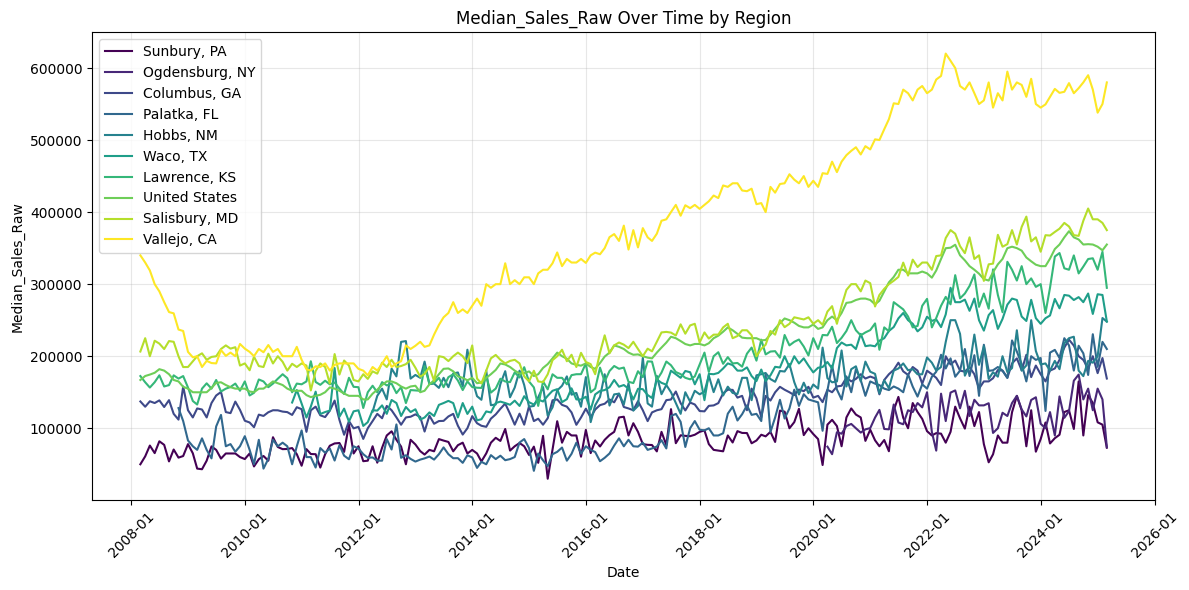

In [484]:
us_id = 102001 # Region ID of the USA as a whole in the data

PlottingModels.plot_time_series(sample_of_regions(metro_sales_raw, "Median_Sales_Raw", [us_id]), "Metro_Sales_Raw_Data", "Metro_Location_Data", "Median_Sales_Raw")

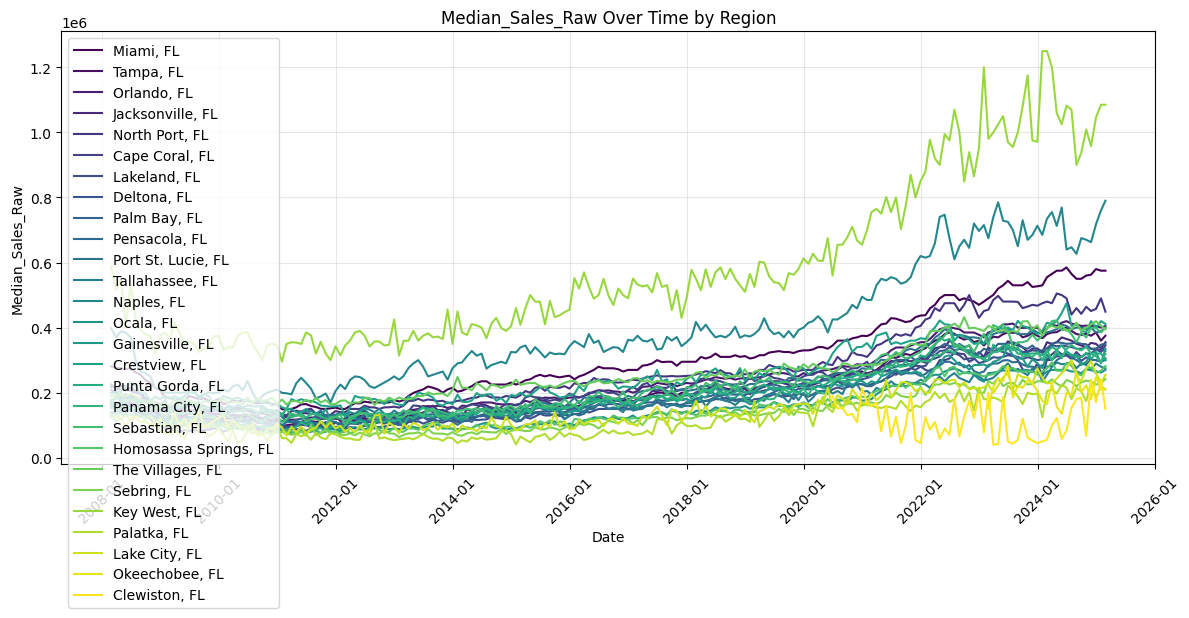

In [511]:
PlottingModels.plot_time_series(state_regions(continental_sales_raw_df, 'fl'), "Metro_Sales_Raw_Data", "Metro_Location_Data", "Median_Sales_Raw")

In [ ]:
PlottingModels.plot_time_series()

In [ ]:
metro_merged_df = DB.select_merged_table({"Metro_Sales_Data", "Metro_Location_Data"}, key_value=us_id, cols=["Date", "Median_Sales"])
metro_merged_df["Date"] = pd.to_datetime(metro_merged_df["Date"], errors="coerce")
metro_merged_df.set_index("Date", inplace=True)

# Decompose into trend, seasonality, and residual
decomposition = seasonal_decompose(metro_merged_df, model='multiplicative')
decomposition.plot()
plt.show()

In [ ]:
raw_metro_merged_df = DB.select_merged_table({"Metro_Sales_Raw_Data", "Metro_Location_Data"}, key_value=us_id, cols=["Date", "Median_Sales_Raw"])
raw_metro_merged_df["Date"] = pd.to_datetime(raw_metro_merged_df["Date"], errors="coerce")
raw_metro_merged_df.set_index("Date", inplace=True)

# Decompose into trend, seasonality, and residual
raw_decomposition = seasonal_decompose(raw_metro_merged_df, model='multiplicative')
raw_decomposition.plot()
plt.show()

**Insight**
1. After 2012, the trend line grows fairly steadily until 2020, where the trend line increases faster, before leveling off at 2022 and is seemingly increasing at a rate between what it was from 2012-2020 and what it was between 2020-2022. Overrall it shows a long term growth.
2. There is a regularly repeating pattern, suggesting prices rise and fall consistently with the seasons.
3. The data seems to be multiplicative since the variation increases over time, and since the trend and seasonality are both reasonably strong, more complex models are justified.

In [ ]:
class Forecast:
    def __init__(self, df : pd.DataFrame, percentage : float=0.8):
        """
        Initializes the forecasting class with a dataframe and train/test split percentage
        
        Parameters:
            df (pd.DataFrame): A dataframe with time series data to forecast
            percentage (float, default=0.8): Percentage of data to use for training
        """
        self.df = df
        self.train_size = int(len(df) * percentage)
        self.train, self.test = df.iloc[:self.train_size], df.iloc[self.train_size:] # The first 80% of data is for training (by default), the remaining is for testing since past predicts future
        self.forecasts = {}
        self.metrics = {}
    
    def fit_arima(self, order : tuple=(5, 1, 0), model_name : str="ARIMA"):
        """
        Fits an ARIMA model to the training data
        
        Parameters
            order (tuple): ARIMA order parameters (p, d, q)
            model_name (str): Name to identify this model in results
        """
        model = ARIMA(self.train, order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(self.test))
        
        # Stores the forecast results
        self.forecasts[model_name] = forecast
        self._calculate_metrics(model_name)
        
        return forecast
    
    def fit_holtwinters(self, trend : str="add", seasonal : str="add", seasonal_periods : int=12, model_name : str="Holt-Winters"):
        """
        Fits a Holt-Winters model to the training data
        
        Parameters:
            trend (str, default="add"): Type of trend component ('add', 'mul', or None)
            seasonal (str, default="add"): Type of seasonal component ('add', 'mul', or None)
            seasonal_periods (int): Number of time steps in a seasonal period
            model_name (str): Name to identify this model in results
        """
        model = ExponentialSmoothing(self.train, trend=trend, seasonal=seasonal, 
                                     seasonal_periods=seasonal_periods)
        model_fit = model.fit()
        forecast = model_fit.forecast(len(self.test))
        
        # Stores the forecast results
        self.forecasts[model_name] = forecast
        self._calculate_metrics(model_name)
        
        return forecast
    
    def fit_sarima(self, order : tuple=(1,1,1), seasonal_order : tuple=(1,1,1,12), model_name : str="SARIMA"):
        """
        Fits a SARIMA model to the training data
        
        Parameters:
            order (tuple): SARIMA order parameters (p, d, q)
            seasonal_order (tuple): SARIMA seasonal_order parameters (P, D, Q, S)
            model_name (str): Name to identify this model in results
        """
        model = SARIMAX(self.train, order=order, seasonal_order=seasonal_order)
        
        model_fit = model.fit()
        forecast = model_fit.forecast(len(self.test))

        # Store forecast results
        self.forecasts[model_name] = forecast
        self._calculate_metrics(model_name)
        
        return forecast
    
    def _calculate_metrics(self, model_name : str):
        """
        Calculate error metrics for a given model's forecast
        
        Parameters:
            model_name (str): The name of the model as it is stored in self.forecasts 
        """
        forecast = self.forecasts[model_name]
        
        mae = mean_absolute_error(self.test, forecast)
        mse = mean_squared_error(self.test, forecast)
        rmse = np.sqrt(mse)
        
        self.metrics[model_name] = {
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse
        }
    
    def plot_forecast(self, model_name : str, figsize : tuple=(12, 6), linestyle : str="--"):
        """
        Plot a specific forecast against actual data
        
        Parameters:
            model_name (str): Name of the forecast to plot as stored in self.forecasts
            figsize (tuple): Figure size for the plot
            linestyle (str): Line style for the forecast line
        """
        if model_name not in self.forecasts:
            raise ValueError(f"Model {model_name} has not been fitted yet")
            
        forecast = self.forecasts[model_name]
        
        plt.figure(figsize=figsize)
        plt.plot(self.train, label="Training Data")
        plt.plot(self.test, label="Actual Test Data")
        plt.plot(self.test.index, forecast, label=f"{model_name} Forecast", linestyle=linestyle)
        plt.legend()
        plt.title(f"{model_name} Model Forecasting")
        plt.show()
    
    def plot_all_forecasts(self, figsize : tuple=(12, 6)):
        """
        Plots all created forecasts at once for comparison
        
        Parameters:
            figsize (tuple): Figure size of the plot
        """
        plt.figure(figsize=figsize)
        plt.plot(self.train, label="Training Data", color="blue")
        plt.plot(self.test, label="Actual Test Data", color="green")
        
        colors = ["red", "purple", "orange", "brown", "pink"]
        linestyles = ["--", "-.", ":", "-"]
        
        for i, (name, forecast) in enumerate(self.forecasts.items()):
            plt.plot(self.test.index, forecast, 
                     label=f"{name} Forecast", 
                     linestyle=linestyles[i % len(linestyles)],
                     color=colors[i % len(colors)])
        
        plt.legend()
        plt.title("Forecasting Models Comparison")
        plt.show()
    
    def print_metrics(self, model_name : str=None):
        """
        Print metrics for a specific model or all models
        
        Parameters:
            model_name (str, default=None): Name of the model to print metrics for (if None, print all)
        """
        if model_name is not None:
            if model_name not in self.metrics:
                raise ValueError(f"Model {model_name} has not been fitted yet")
            
            metrics = self.metrics[model_name]
            print(f"=== {model_name} Metrics ===")
            print(f"{model_name} MAE: {metrics['MAE']:.4f}")
            print(f"{model_name} MSE: {metrics['MSE']:.4f}")
            print(f"{model_name} RMSE: {metrics['RMSE']:.4f}")
            print()
            
        else:
            for name, metrics in self.metrics.items():
                print(f"=== {name} Metrics ===")
                print(f"{name} MAE: {metrics['MAE']:.4f}")
                print(f"{name} MSE: {metrics['MSE']:.4f}")
                print(f"{name} RMSE: {metrics['RMSE']:.4f}")
                print()
    
    def get_best_model(self, metric : str="MSE"):
        """
        Get the name of the best performing model based on a specific metric
        
        Parameters:
            metric (str): Metric to use for comparison ('MAE', 'MSE', or 'RMSE')
            
        Returns:
            Name of the best model (str)
        
        Raises:
            ValueError: If no models have been forecasted/fitted
        """
        if not self.metrics:
            raise ValueError("No models have been fitted yet")
            
        best_model = min(self.metrics.keys(), 
                         key=lambda model: self.metrics[model][metric])
        
        return best_model

In [ ]:
forecast = Forecast(metro_merged_df)
forecast.fit_arima()
forecast.fit_holtwinters(seasonal_periods=52)
forecast.fit_sarima(seasonal_order=(1,1,1,52))
forecast.plot_all_forecasts()

In [ ]:
forecast.print_metrics()
for metric in ["MAE", "MSE", "RMSE"]:
    print(f"The model with the best {metric} score is {forecast.get_best_model(metric=metric)}")

In [ ]:
raw_forecast = Forecast(raw_metro_merged_df)
raw_forecast.fit_arima()
raw_forecast.fit_holtwinters(trend="add", seasonal="mul", seasonal_periods=12)
raw_forecast.fit_sarima(seasonal_order=(1,1,1,12))
raw_forecast.plot_all_forecasts()
forecast.print_metrics()
for metric in ["MAE", "MSE", "RMSE"]:
    print(f"The model with the best {metric} score is {forecast.get_best_model(metric=metric)}")